## Homework #1 : Seasonality, Stability and detrending

1.  Pick a stock and download the last 250 trading days (1 year).  Graph the stock price.  Can you calculate the observed auto correlation function? Does there appear to be a trend? How about seasonality?   There is no correct / wrong answer for trend / seasonality. Just look at the data and describe it.

2. For your stock detrend the data using the following methods. i) Linear regression of price vs time ii) moving average function.   Plot the detrended data

3. Download retail sales data for the last 10 years.  Remove the seasonality of the data.  After that try to remove inflation but using log of sales vs time in a linear regression.

3. Stoffer Problem 1.7 : 

    For a moving average process of the form

    $$x_t = w_{t-1} + 2w_t + w_t$$

    find the autocorrelatin and autocovariance function

4. Assume $Z_t$ are iid normal with mean 0 and standard deviation sigma

    which of the following are stationary

    $$X_t = a + bZ_t + cZ_{t-1}$$ 

    $$X_t = Z_1 cos(ct) + Z_2 sin(ct)$$

    $$X_t = Z_0 cos(ct)$$

    $$X_t = Z_tZ_{t-1}$$

    $$X_t = a + bZ_t + ct$$

In [13]:
import numpy as np
import datetime
import holidays
import pandas as pd
from pandas_datareader import data, wb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
def n_business_day_before(test_date, n):
    ONE_DAY = datetime.timedelta(days=1)
    HOLIDAYS_US = holidays.US()
    last_day = test_date
    for _ in range(n):
        last_day = last_day - ONE_DAY
        while last_day.weekday() in holidays.WEEKEND or last_day in HOLIDAYS_US:
            last_day -= ONE_DAY
    return last_day 

def data_preparation(ticker_name, test_date):
    start_date = n_business_day_before(test_date, 249)
    price_df = data.DataReader(ticker_name, 'yahoo', start_date, test_date)
    price_df = price_df[['Adj Close']]
    return price_df

def plot_one_column(df, column_name):
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    gx.plot(df.index, df[column_name], color='blue', label=column_name)
    gx.set_xlabel('Dates',size=40, fontsize=30)
    gx.set_ylabel(column_name, fontsize=30)
    gx.set_title(column_name, size=40)
    gx.grid(True)
    
test_date = datetime.datetime(2019, 9, 13)
ticker_name = 'AMZN'
AMZN_df = data_preparation(ticker_name, test_date)
AMZN_df.head()

,Adj Close
Date,
2018-09-17,1908.030029
2018-09-18,1941.050049
2018-09-19,1926.420044
2018-09-20,1944.300049
2018-09-21,1915.010010


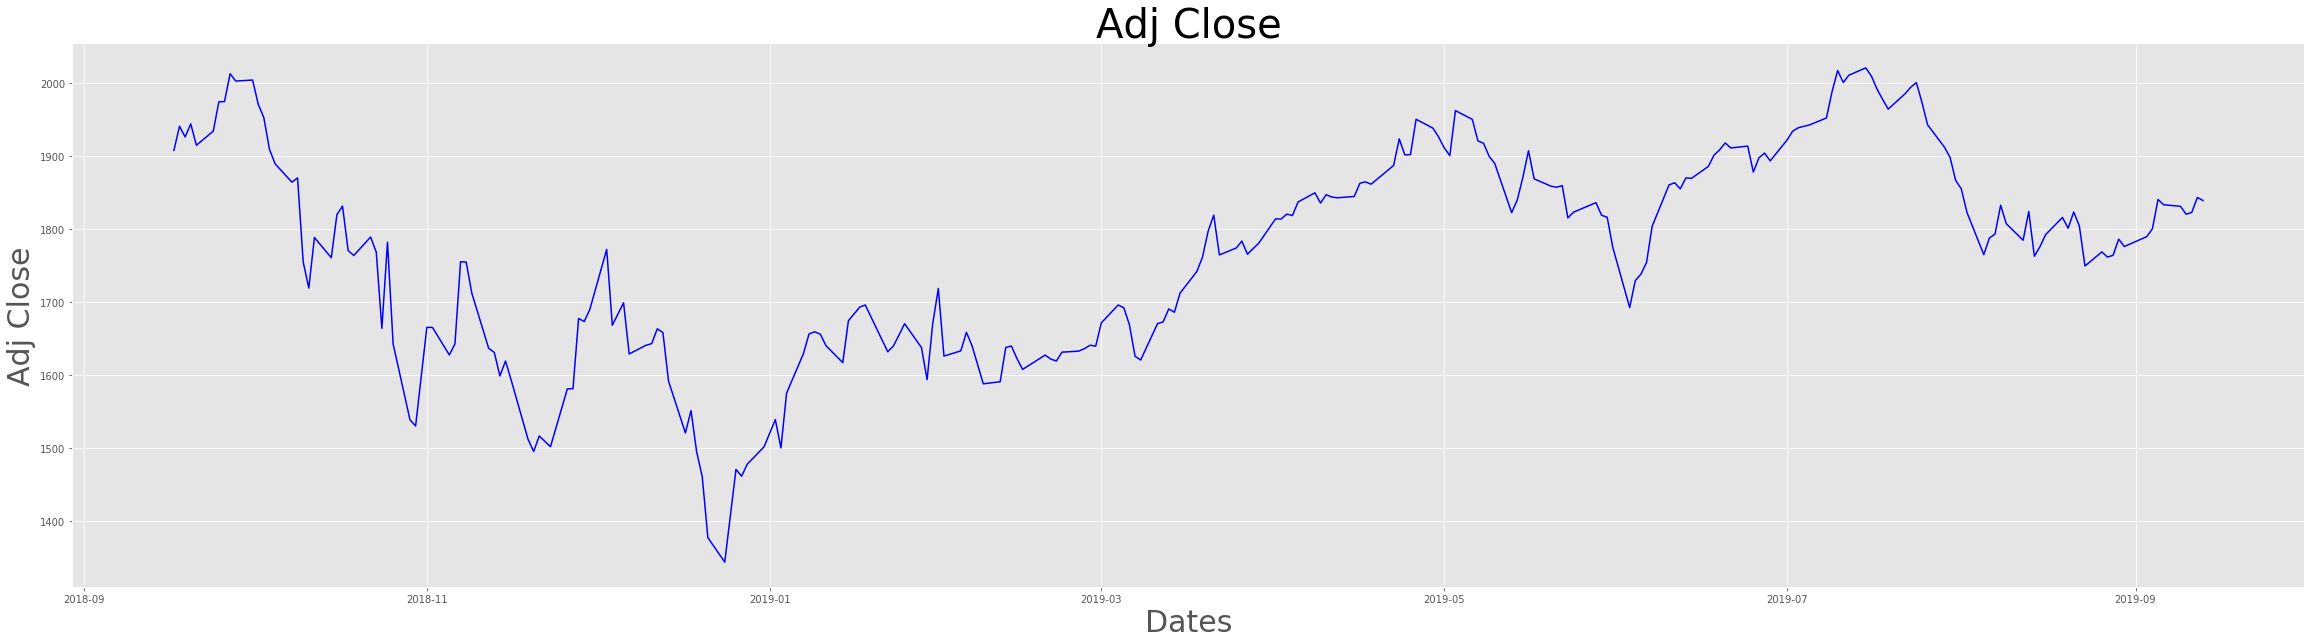

In [4]:
plot_one_column(AMZN_df, 'Adj Close')

### plot auto correlation function

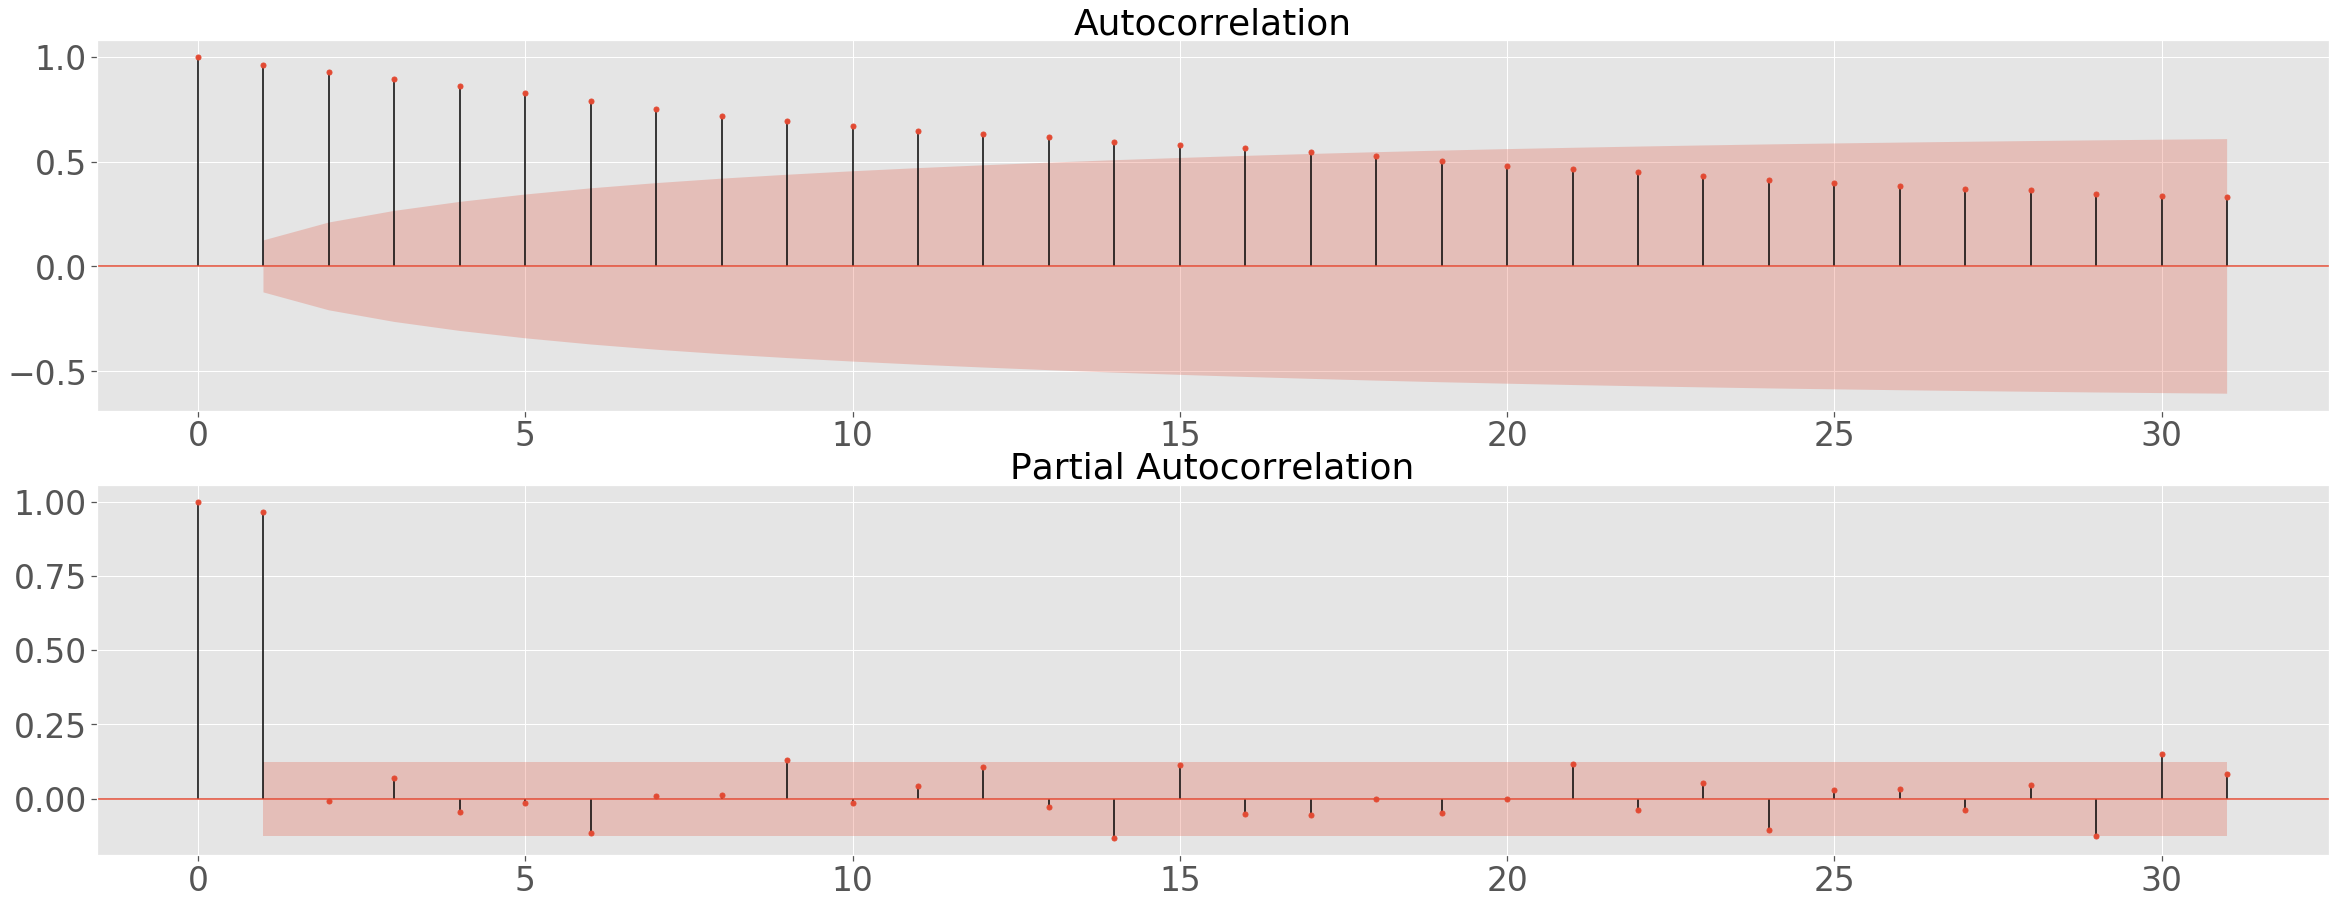

In [5]:
def draw_acf_pacf(ts, lags=31):
    sns.set_context('notebook', font_scale=3.0)
    f = plt.figure(facecolor='white', figsize=(40,15))
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)  
    plt.show()
    
draw_acf_pacf(AMZN_df)

### Detrend Data Using Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

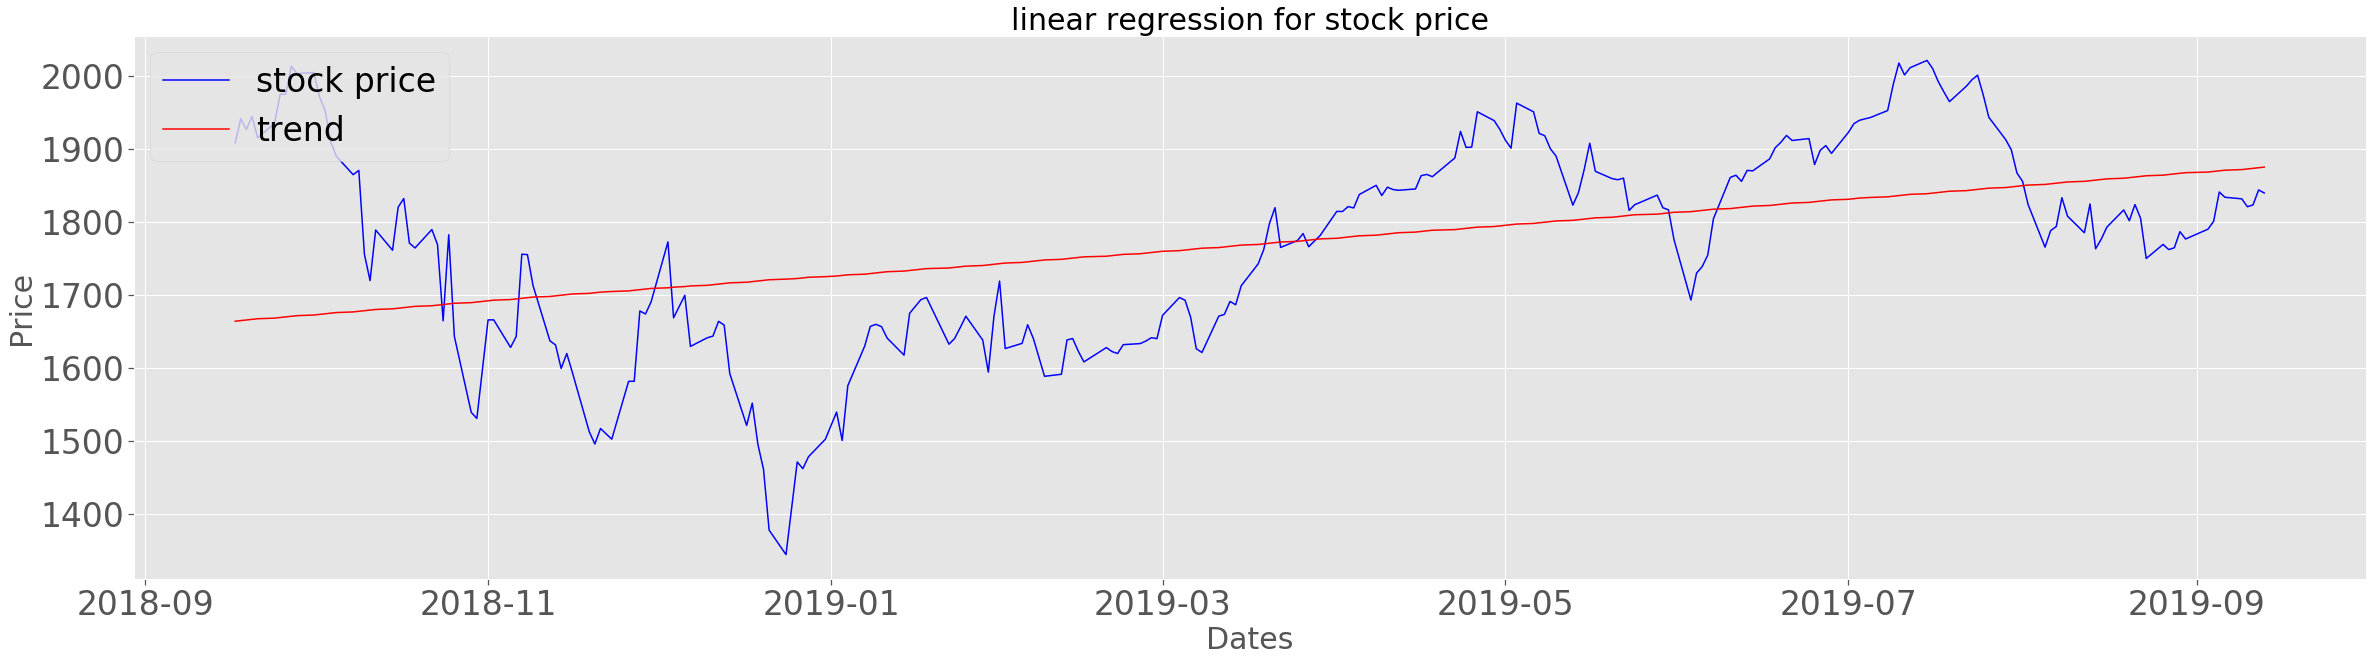

In [7]:
def lr_model(df):
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    X = [i for i in range(0, len(df))]
    X = np.reshape(X, (len(X), 1))
    y_true = df.values
    model = LinearRegression()
    model.fit(X, y_true)
    # calculate trend
    y_trend = model.predict(X)
    # plot trend
    x_date = df.index
    gx.plot(x_date, y_true, 'b', label='stock price')
    gx.plot(x_date, y_trend, 'r', label='trend')
    gx.legend(loc=2)
    gx.set_xlabel('Dates',size=40, fontsize=30)
    gx.set_ylabel('Price', fontsize=30)
    gx.set_title('linear regression for stock price', fontsize=30)
    plt.show()
    return y_true, y_trend, x_date

y_true, y_trend, x_date = lr_model(AMZN_df)

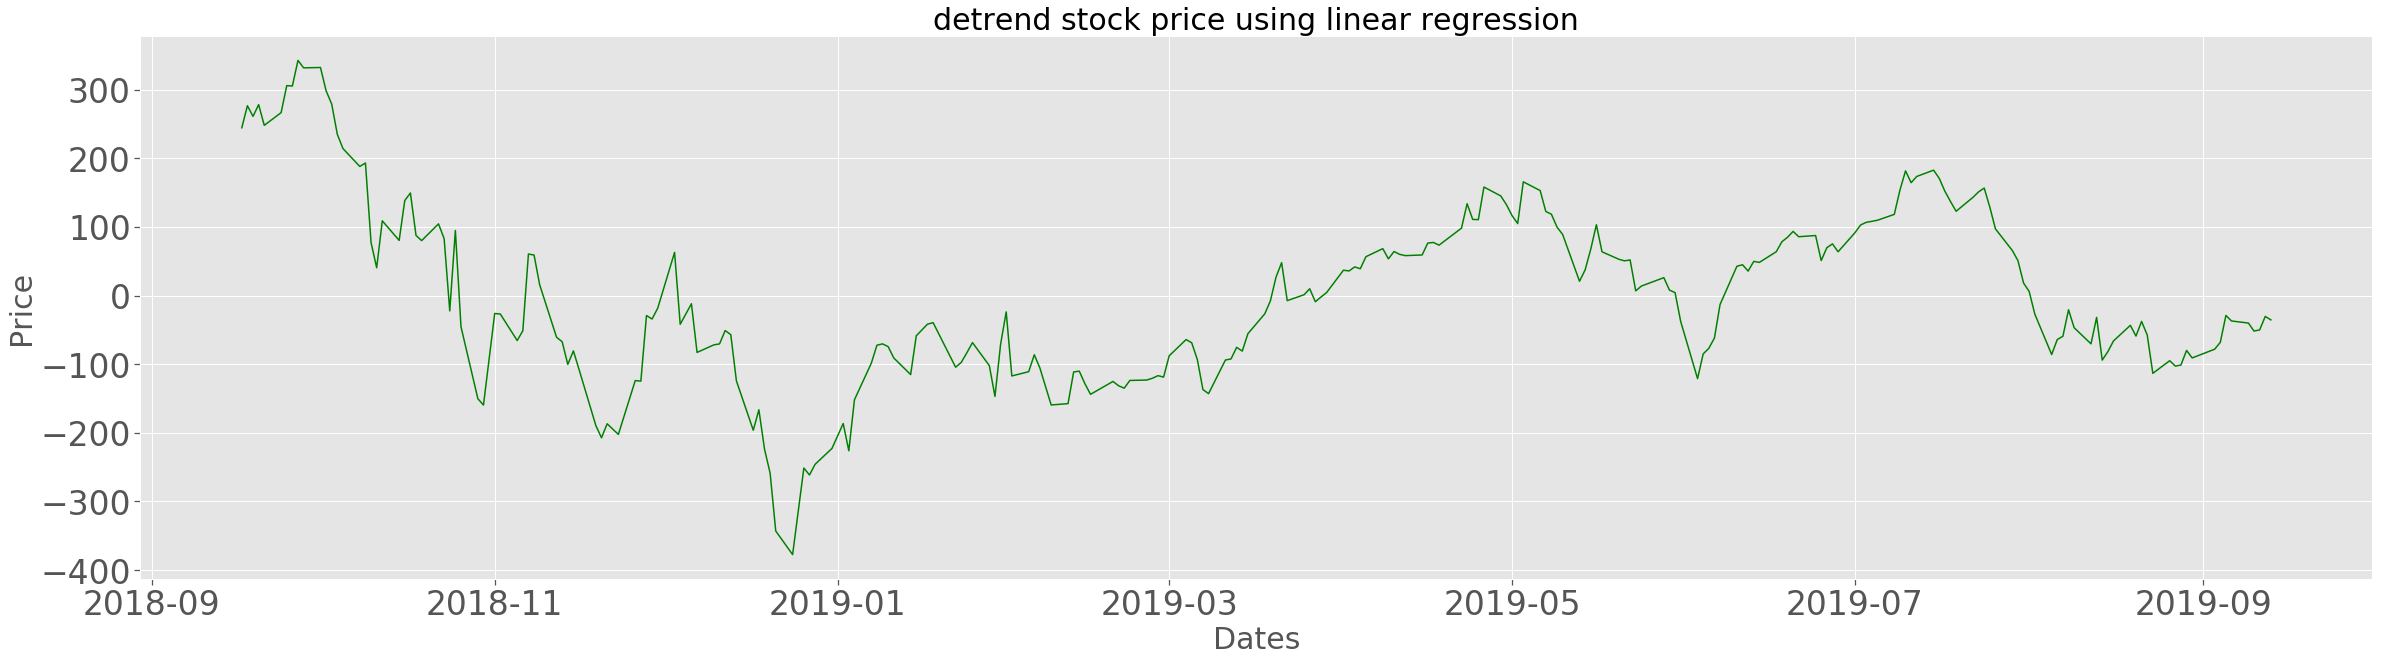

In [8]:
# detrend

def detrend(y_true, y_trend, x_date, title):
    detrended = [y_true[i]-y_trend[i] for i in range(0, len(y_true))]
    # plot detrended
    fig, gx = plt.subplots(figsize = (40,10))
    gx.set_xlabel('Dates',size=40, fontsize=30)
    gx.set_ylabel('Price', fontsize=30)
    gx.set_title(title, fontsize=30)
    gx.plot(x_date, detrended, 'g')
    plt.show()
    
detrend(y_true, y_trend, x_date, 'detrend stock price using linear regression')

### Detrend Data Using Moving Average

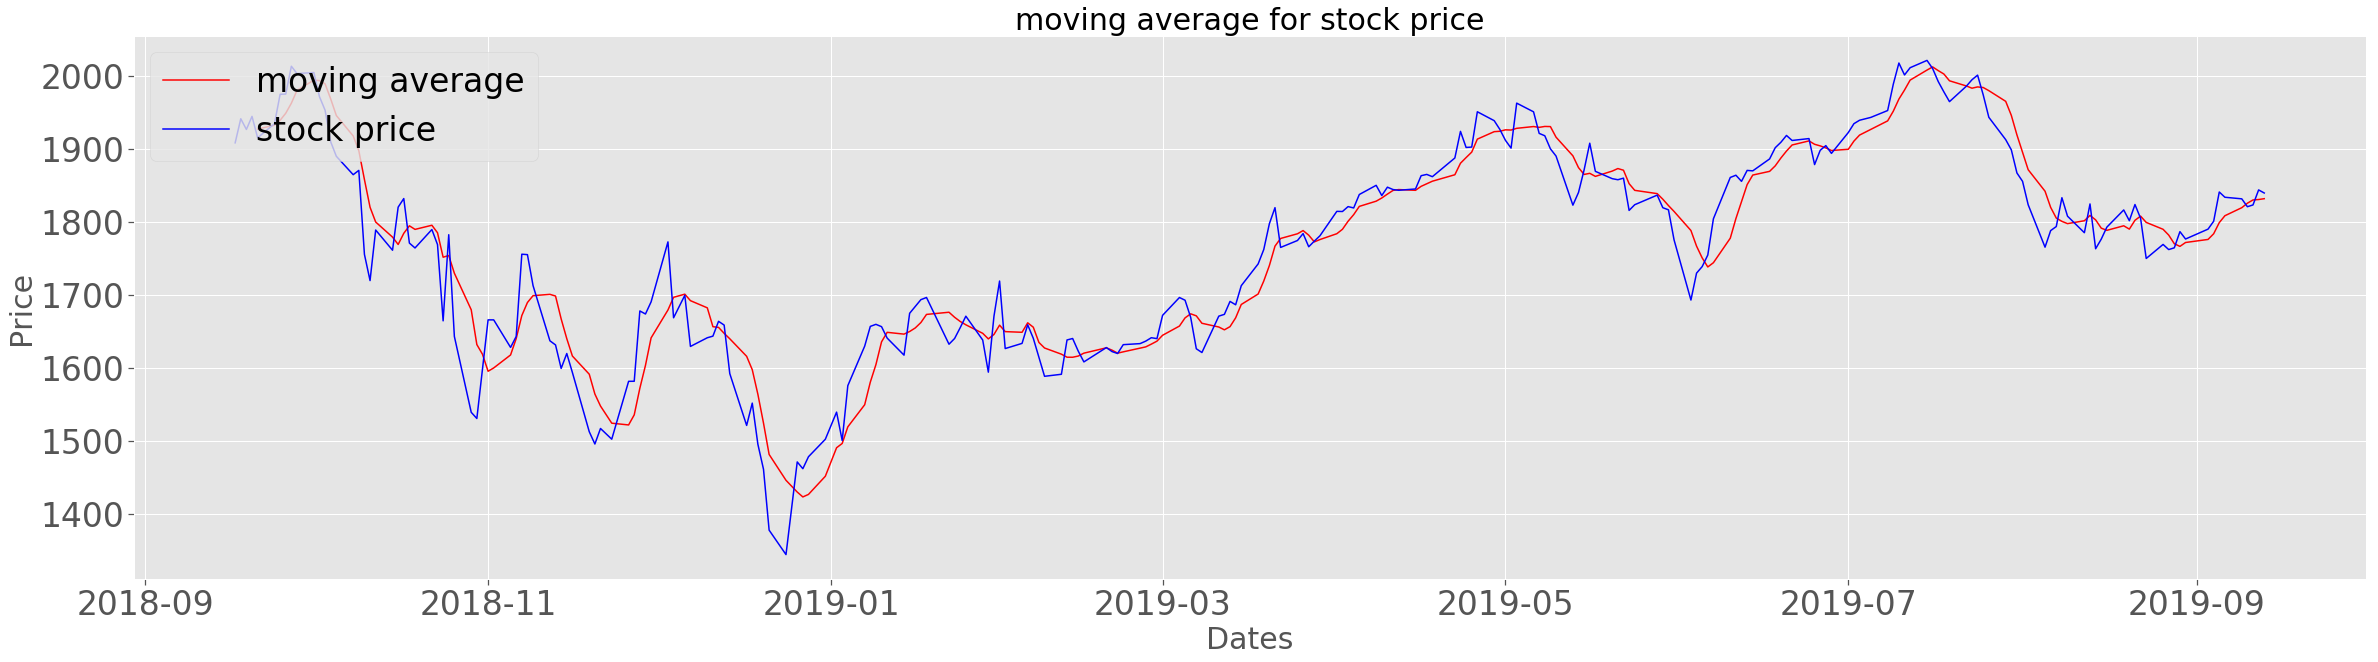

In [9]:
def moving_average(df):
    y_ma = df['Adj Close'].rolling(window=5).mean()
    y_true = df.values
    x_date = df.index
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.plot(x_date, y_ma, 'r',label='moving average') 
    gx.plot(x_date, y_true, 'b', label = 'stock price')
    gx.legend(loc=2)
    gx.set_xlabel('Dates',size=40, fontsize=30)
    gx.set_ylabel('Price', fontsize=30)
    gx.set_title('moving average for stock price', fontsize=30)
    plt.show()
    return x_date, y_true, y_ma
    
x_date, y_true, y_ma = moving_average(AMZN_df)

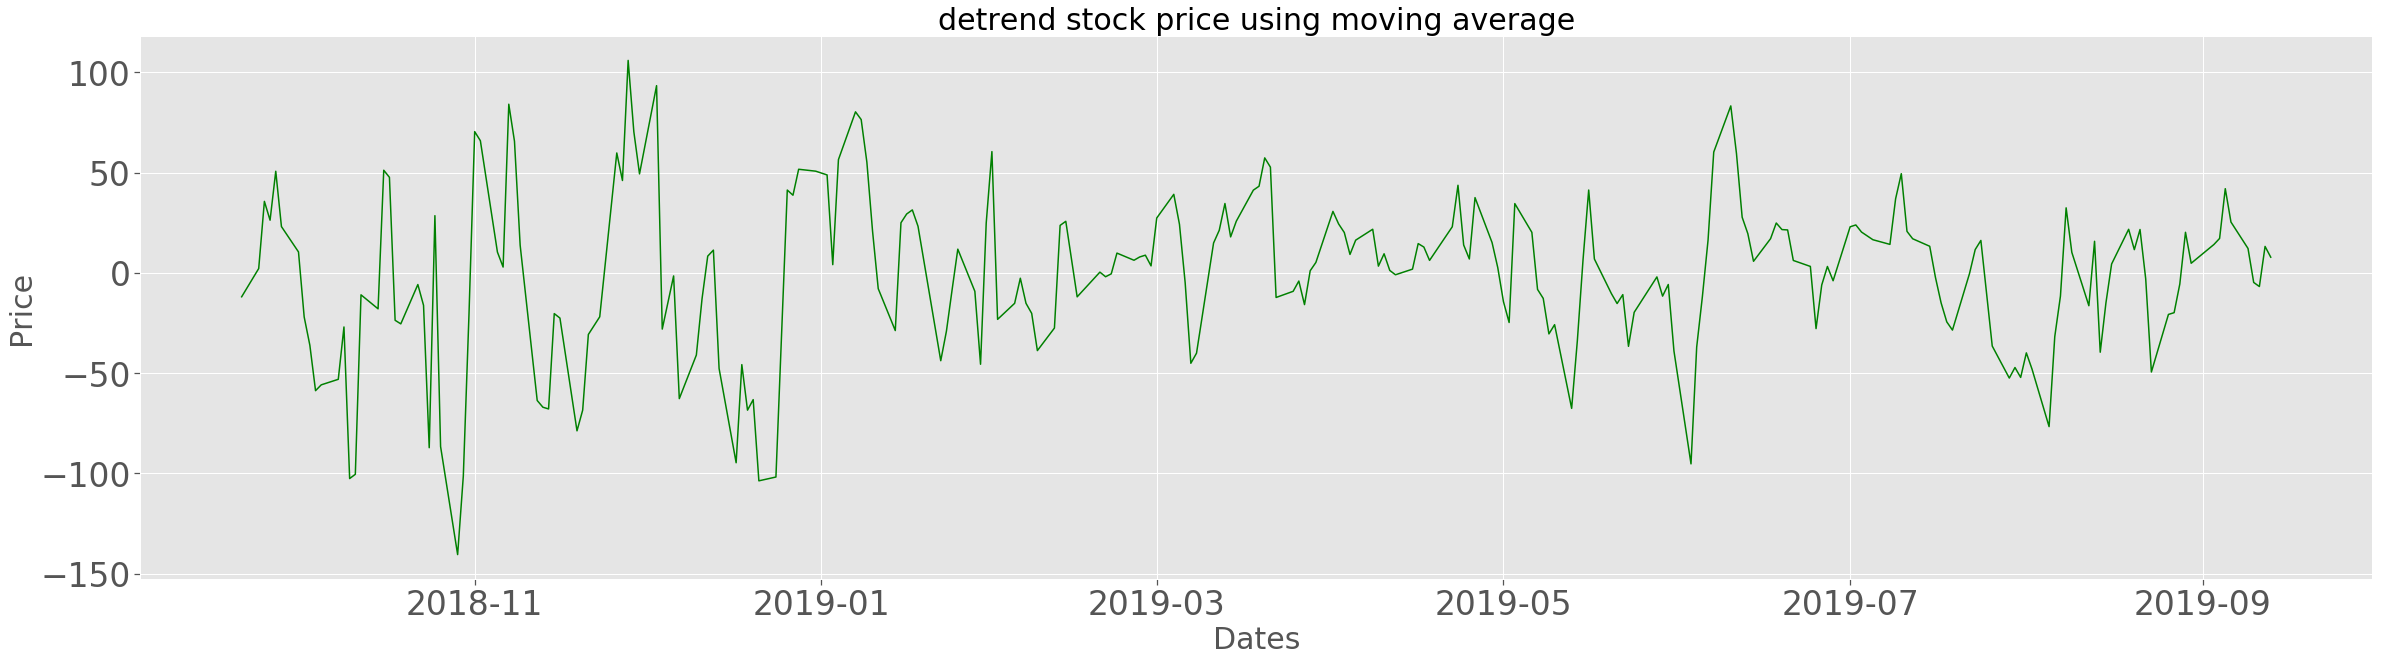

In [10]:
detrend(y_true, y_ma, x_date, 'detrend stock price using moving average')

### Retail Sales 

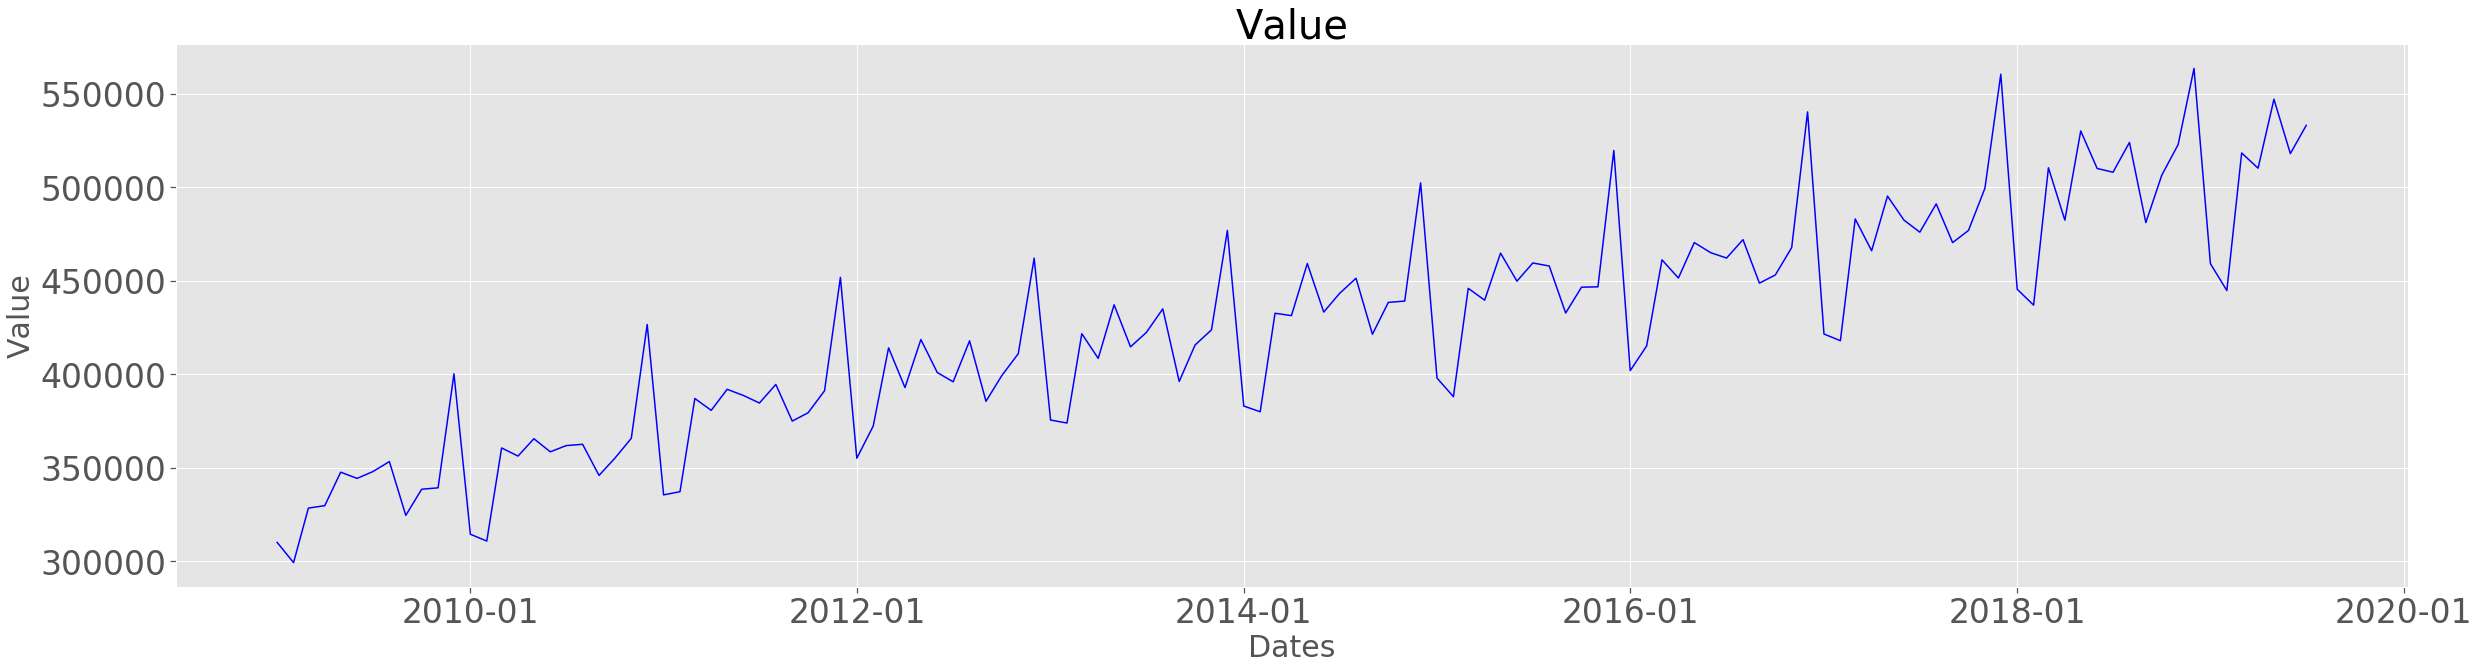

In [11]:
path = '../HW1-Seasonality-Stability-and-Detrending/RetailSales.csv'

def retail_data_prepare(path):
    retail_sales=pd.read_csv(path)
    retail_sales['Period'] =  pd.to_datetime(retail_sales['Period'], format='%b-%Y')
    retail_sales = retail_sales.dropna()
    retail_sales = retail_sales.set_index('Period')
    plot_one_column(retail_sales, 'Value')
    return retail_sales

retail_sales = retail_data_prepare(path)

### Remove the seasonality of the data

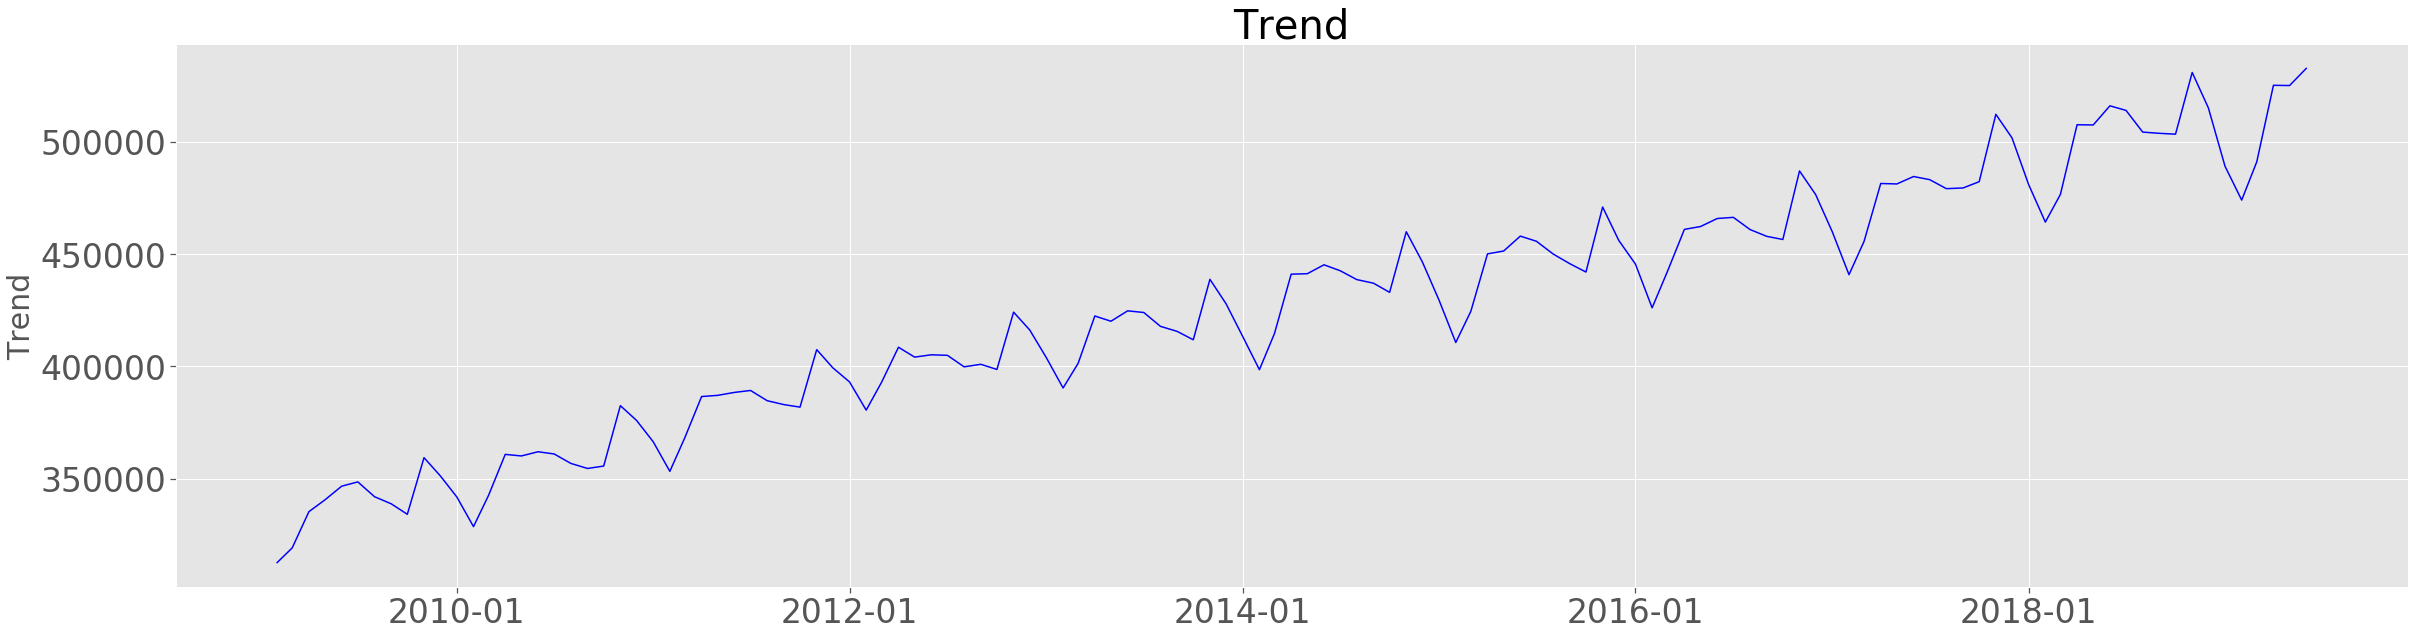

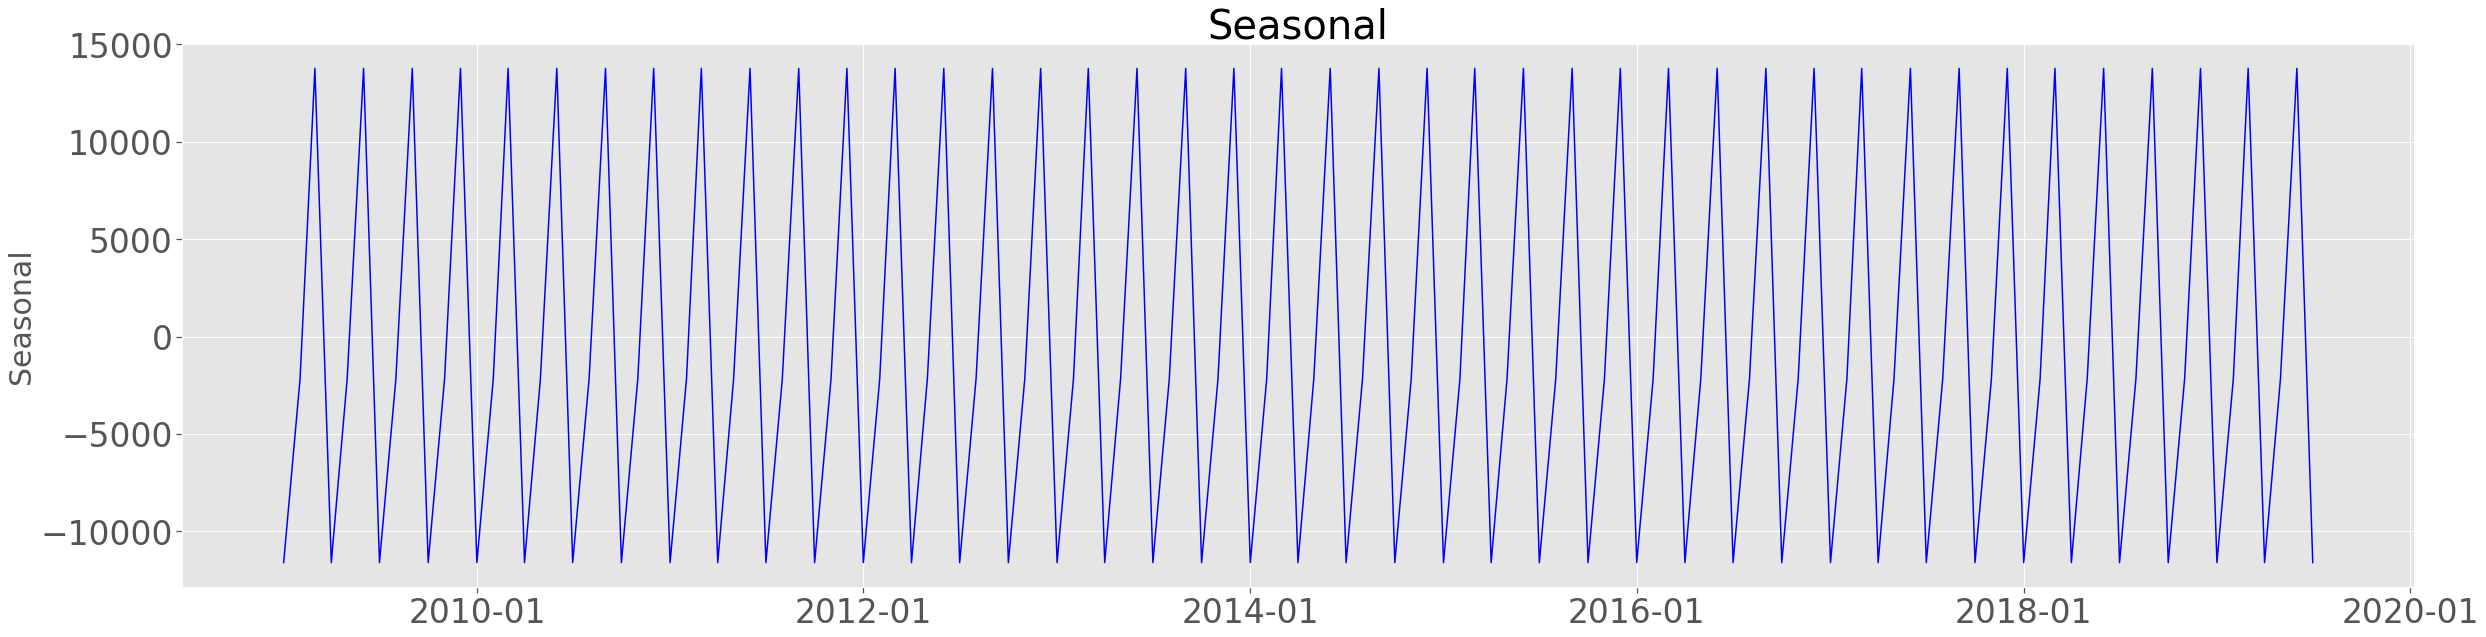

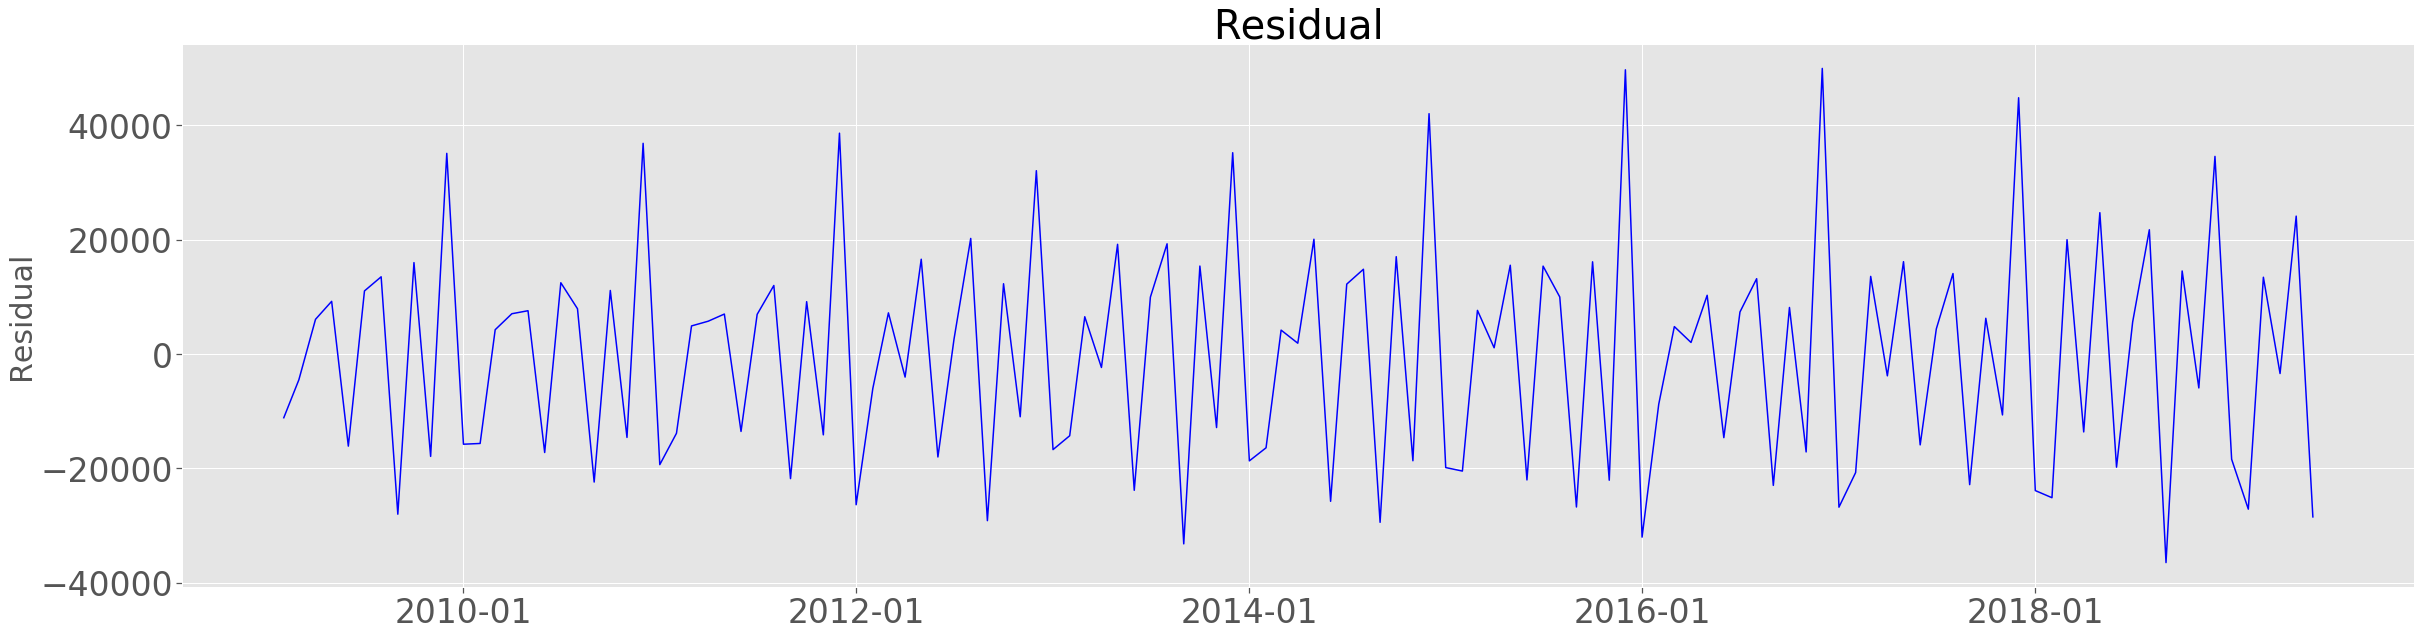

In [14]:
def plot_time_series(df, title):
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    gx.plot(df, color='blue')
#     gx.set_xlabel('Dates',size=40, fontsize=30)
    gx.set_ylabel(title, fontsize=30)
    gx.set_title(title, size=40)
    gx.grid(True)

decomposition = seasonal_decompose(retail_sales.Value, model='Additive',freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# plot_time_series(trend, 'trend')
plot_time_series(trend, 'Trend')
plot_time_series(seasonal, 'Seasonal')
plot_time_series(residual, 'Residual')

def remove_seasonality(retail_sales, ):
    y_ma = df['Adj Close'].rolling(window=5).mean()
    y_true = df.values
    x_date = df.index
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.plot(x_date, y_ma, 'r',label='moving average') 
    gx.plot(x_date, y_true, 'b', label = 'stock price')
    gx.legend(loc=2)
    gx.set_xlabel('Dates',size=40, fontsize=30)
    gx.set_ylabel('Price', fontsize=30)
    gx.set_title('moving average for stock price', fontsize=30)
    plt.show()
    return x_date, y_true, y_ma

### remove inflation but using log of sales vs time in a linear regression.